# Compare old and new supervised NSM codes

In [1]:
import time
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm.auto import tqdm

from pynsm import Supervised_NSM_Conv, SupervisedSimilarityMatching

## Load dataset and create data loaders

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

train_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)
classes = [str(i) for i in range(10)]

In [3]:
# Create training and test dataloaders
# number of subprocesses to use for data loading
# TT: num_workers > 0 can be problematic in notebooks
num_workers = 0
# how many samples per batch to load
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

batch min=0, mean=0.136, max=1


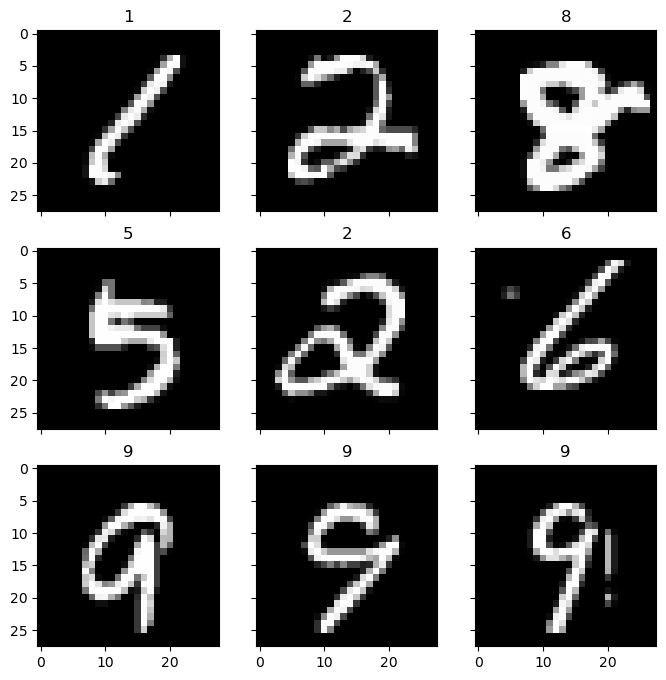

In [4]:
# show sample images
torch.manual_seed(42)

X_batch, y_batch = next(iter(train_loader))
X_max = X_batch.max()
X_min = X_batch.min()

print(f"batch min={X_min:.3g}, mean={X_batch.mean():.3g}, max={X_max:.3g}")

# create a grid of 3x3 images
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 8))
for i in range(3):
    for j in range(3):
        batch_idx = i * 3 + j
        crt_X = X_batch[batch_idx]
        ax[i][j].imshow(crt_X.numpy().squeeze(), vmin=X_min, vmax=X_max, cmap="gray")
        ax[i][j].set_title(classes[y_batch[batch_idx].item()])

## Try the supervised convolutional NSM module

Check that the output of `forward()` matches.

In [5]:
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

num_labels = len(classes)
alpha = 1e-1
tau = 1e-1
tauLabel = 1e0
model = Supervised_NSM_Conv(
    1, 50, 6, num_labels, etaW=1e-3, etaM=1e-3, tau=tau, tauLabel=tauLabel
)

encoder = torch.nn.Conv2d(1, 50, 6)
encoder.weight.data = model.encoder.weight.detach().clone()
encoder.bias.data = model.encoder.bias.detach().clone()
encoder.bias.requires_grad_(False)
new_model = SupervisedSimilarityMatching(
    encoder, num_labels, 50, label_bias=True, iteration_projection=torch.nn.ReLU()
)

new_model.encoders[1].weight.data = 36 * model.encoder_labels.weight.mean(dim=[2, 3]).detach().clone()
new_model.encoders[1].bias.data = model.encoder_labels.bias.detach().clone()

new_model.competitor.weight.data = model.competitor.weight.detach().clone()

model = model.to(device=device, dtype=torch.float64)
new_model = new_model.to(device=device, dtype=torch.float64)

torch.manual_seed(42)

images, labels = next(iter(train_loader))
images = images.to(device=device, dtype=torch.float64)
labels = labels.to(device=device)

one_hot_labels = F.one_hot(labels, num_classes=num_labels)
repeat_labels = torch.tile(
    alpha * one_hot_labels[:, :, None, None], images.shape[2:4]
).to(dtype=torch.float64)
out = model(images, 10 * repeat_labels)

new_out = new_model(images, one_hot_labels.to(dtype=torch.float64))

Running on cuda:0.


/mnt/home/ttesileanu/miniconda3/envs/pynsm/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [6]:
(out - new_out).abs().max()

tensor(1.1708e-07, device='cuda:0', dtype=torch.float64)

Check that the output of `loss()` matches.

In [7]:
torch.manual_seed(42)

model = Supervised_NSM_Conv(
    1, 50, 6, num_labels, etaW=1e-3, etaM=1e-3, tau=tau, tauLabel=tauLabel
)

encoder = torch.nn.Conv2d(1, 50, 6)
encoder.weight.data = model.encoder.weight.detach().clone()
encoder.bias.data = model.encoder.bias.detach().clone()
encoder.bias.requires_grad_(False)
new_model = SupervisedSimilarityMatching(
    encoder, num_labels, 50, label_bias=True, iteration_projection=torch.nn.ReLU()
)

new_model.encoders[1].weight.data = 36 * model.encoder_labels.weight.mean(dim=[2, 3]).detach().clone()
new_model.encoders[1].bias.data = model.encoder_labels.bias.detach().clone()
new_model.encoders[1].bias.requires_grad_(False)

new_model.competitor.weight.data = model.competitor.weight.detach().clone()

model = model.to(device=device, dtype=torch.float64)
new_model = new_model.to(device=device, dtype=torch.float64)

torch.manual_seed(42)

images, labels = next(iter(train_loader))
images = images.to(device=device, dtype=torch.float64)
labels = labels.to(device)

one_hot_labels = F.one_hot(labels, num_classes=num_labels)
repeat_labels = torch.tile(
    alpha * one_hot_labels[:, :, None, None], images.shape[2:4]
).to(device=device, dtype=torch.float64)
out = model(images, 10 * repeat_labels)
loss = model.loss_NSM_conv(
    out, images.to(device), repeat_labels, print_=False
).item()

new_out = new_model(images, one_hot_labels.to(torch.float64))

assert (out - new_out).abs().max() < 1e-6

new_loss = new_model.loss(images, one_hot_labels.to(torch.float64) / 10, new_out).item()

In [8]:
new_loss - loss / 50

4.942712905631197e-13

Finally, check the updates.

In [9]:
torch.manual_seed(42)

model = Supervised_NSM_Conv(
    1, 50, 6, num_labels, etaW=1e-3, etaM=1e-3, tau=tau, tauLabel=tauLabel
)

encoder = torch.nn.Conv2d(1, 50, 6)
encoder.weight.data = model.encoder.weight.detach().clone()
encoder.bias.data = model.encoder.bias.detach().clone()
encoder.bias.requires_grad_(False)
new_model = SupervisedSimilarityMatching(
    encoder, num_labels, 50, label_bias=True, iteration_projection=torch.nn.ReLU()
)

new_model.encoders[1].weight.data = 36 * model.encoder_labels.weight.mean(dim=[2, 3]).detach().clone()
new_model.encoders[1].bias.data = model.encoder_labels.bias.detach().clone()
new_model.encoders[1].bias.requires_grad_(False)

new_model.competitor.weight.data = model.competitor.weight.detach().clone()

model = model.to(device=device, dtype=torch.float64)
new_model = new_model.to(device=device, dtype=torch.float64)

optimizer = torch.optim.SGD(new_model.parameters(), lr=0.05)

torch.manual_seed(42)

images, labels = next(iter(train_loader))
images = images.to(device=device, dtype=torch.float64)
labels = labels.to(device)

one_hot_labels = F.one_hot(labels, num_classes=num_labels)
repeat_labels = torch.tile(
    alpha * one_hot_labels[:, :, None, None], images.shape[2:4]
).to(device=device, dtype=torch.float64)
out = model(images, 10 * repeat_labels)
loss = model.loss_NSM_conv(
    out, images.to(device), repeat_labels, print_=False
)

new_out = new_model(images, one_hot_labels.to(torch.float64))

assert (out - new_out).abs().max() < 1e-6

new_loss = new_model.loss(images, one_hot_labels.to(torch.float64) / 10, new_out)

assert (new_loss - loss / 50).abs().item() < 1e-6

model0 = deepcopy(model)
new_model0 = deepcopy(new_model)

model.train(out, images, repeat_labels)

optimizer.zero_grad()
new_loss.backward()
optimizer.step()

images, labels = next(iter(train_loader))
images = images.to(device=device, dtype=torch.float64)
labels = labels.to(device)

one_hot_labels = F.one_hot(labels, num_classes=num_labels)
repeat_labels = torch.tile(
    alpha * one_hot_labels[:, :, None, None], images.shape[2:4]
).to(device=device, dtype=torch.float64)
another_out = model(images, 10 * repeat_labels)
another_loss = model.loss_NSM_conv(
    another_out, images.to(device), repeat_labels, print_=False
).item()

another_new_out = new_model(images, one_hot_labels.to(torch.float64))

another_new_loss = new_model.loss(images, one_hot_labels.to(torch.float64) / 10, another_new_out).item()

In [10]:
tmp_db = model.encoder.bias - model0.encoder.bias
tmp_db_new = new_model.encoders[0].bias - new_model0.encoders[0].bias
assert tmp_db.abs().max() < 1e-10
assert tmp_db_new.abs().max() < 1e-10

tmp_dW = model.encoder.weight - model0.encoder.weight
tmp_dW_new = new_model.encoders[0].weight - new_model0.encoders[0].weight
(tmp_dW - tmp_dW_new).abs().max()

tensor(1.1909e-11, device='cuda:0', dtype=torch.float64,
       grad_fn=<MaxBackward1>)

In [11]:
tmp_db = model.encoder_labels.bias - model0.encoder_labels.bias
tmp_db_new = new_model.encoders[1].bias - new_model0.encoders[1].bias
assert tmp_db.abs().max() < 1e-10
assert tmp_db_new.abs().max() < 1e-10

tmp_dW = model.encoder_labels.weight - model0.encoder_labels.weight
tmp_dW_new = new_model.encoders[1].weight - new_model0.encoders[1].weight

assert tmp_dW[2][3].std().item() < 1e-10
tmp_dW = tmp_dW.mean(dim=[2, 3])
(tmp_dW - tmp_dW_new).abs().max()

tensor(3.1194e-12, device='cuda:0', dtype=torch.float64,
       grad_fn=<MaxBackward1>)

In [12]:
tmp_dW = model.competitor.weight - model0.competitor.weight
tmp_dW_new = new_model.competitor.weight - new_model0.competitor.weight
(tmp_dW - tmp_dW_new).abs().max()

tensor(3.1386e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MaxBackward1>)

In [13]:
(new_model.competitor.weight - model.competitor.weight).abs().max()

tensor(3.1386e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MaxBackward1>)

In [14]:
(new_model.encoders[0].weight - model.encoder.weight).abs().max()

tensor(1.1909e-11, device='cuda:0', dtype=torch.float64,
       grad_fn=<MaxBackward1>)

In [15]:
model.encoder_labels.weight[2][3].std()

tensor(0.0445, device='cuda:0', dtype=torch.float64, grad_fn=<StdBackward0>)

Check that the results match on an entire run.

In [16]:
torch.manual_seed(42)
n_epochs = 1

num_labels = len(classes)
running_loss = []
alpha = 1e-1
tau = 1e-1
tauLabel = 1e0
model = Supervised_NSM_Conv(
    1, 50, 6, num_labels, etaW=1e-3, etaM=1e-3, tau=tau, tauLabel=tauLabel
).to(device=device, dtype=torch.float64)

model_copy = deepcopy(model)

t0 = time.time()
torch.manual_seed(42)
for epoch in range(n_epochs):
    pbar = tqdm(train_loader, desc=f"epoch {epoch + 1} / {n_epochs}")
    sample = 0
    for idx, data in enumerate(pbar):
        images, labels = data

        images = images.to(device=device, dtype=torch.float64)
        labels = labels.to(device)

        one_hot_labels = F.one_hot(labels, num_classes=num_labels)
        repeat_labels = torch.tile(
            alpha * one_hot_labels[:, :, None, None], images.shape[2:4]
        ).to(dtype=torch.float64)

        # forward pass
        # XXX why are the labels multiplied by 10 only here??
        outputs = model(images, 10 * repeat_labels)
        # loss estimation
        loss = model.loss_NSM_conv(
            outputs, images.to(device), repeat_labels, print_=False
        )
        # backward pass
        model.train(outputs, images, repeat_labels)
        if device.type == "cuda":
            torch.cuda.empty_cache()

        running_loss.append(loss.item())

        pbar.set_postfix(
            {"sample": sample, "loss": running_loss[-1] / batch_size}, refresh=False
        )
        sample += len(images)

t1 = time.time()
print(f"Training took {t1 - t0:.2f} seconds.")

epoch 1 / 1:   0%|          | 0/600 [00:00<?, ?it/s]

Training took 61.01 seconds.


In [17]:
torch.manual_seed(42)

# the encoder layer is convolutional
encoder = torch.nn.Conv2d(1, 50, 6)
encoder.weight.data = model_copy.encoder.weight.detach().clone()
encoder.bias.data = model_copy.encoder.bias.detach().clone()
encoder.bias.requires_grad_(False)
new_model = SupervisedSimilarityMatching(
    encoder, num_labels, 50, label_bias=True, iteration_projection=torch.nn.ReLU()
)

new_model.encoders[1].weight.data = 36 * model_copy.encoder_labels.weight.mean(
    dim=[2, 3]
).detach().clone()
new_model.encoders[1].bias.data = model_copy.encoder_labels.bias.detach().clone()
new_model.encoders[1].bias.requires_grad_(False)

new_model.competitor.weight.data = model_copy.competitor.weight.detach().clone()

new_model = new_model.to(device=device, dtype=torch.float64)

optimizer = torch.optim.SGD(new_model.parameters(), lr=0.05)

t0 = time.time()
new_running_loss = []
torch.manual_seed(42)
for epoch in range(n_epochs):
    pbar = tqdm(train_loader, desc=f"epoch {epoch + 1} / {n_epochs}")
    sample = 0
    for idx, data in enumerate(pbar):
        images, labels = data

        images = images.to(device=device, dtype=torch.float64)
        one_hot_labels = F.one_hot(labels, num_classes=num_labels).to(
            device=device, dtype=torch.float64
        )

        outputs = new_model(images, one_hot_labels)
        # XXX the original code for some reason uses this different scaling...
        loss = new_model.loss(images, one_hot_labels / 10.0, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        new_running_loss.append(loss.item())

        pbar.set_postfix({"sample": sample, "loss": new_running_loss[-1]}, refresh=False)

        sample += len(images)

t1 = time.time()
print(f"Training took {t1 - t0:.2f} seconds.")

epoch 1 / 1:   0%|          | 0/600 [00:00<?, ?it/s]

Training took 34.79 seconds.


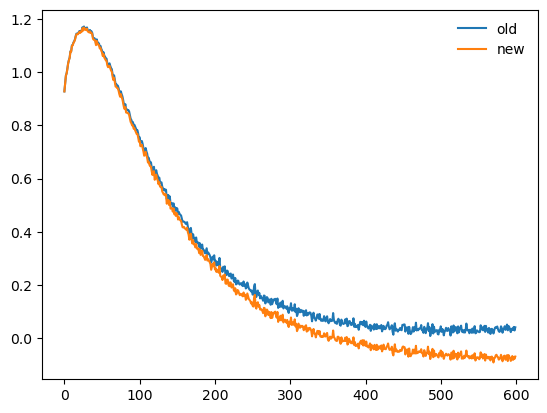

In [18]:
fig, ax = plt.subplots()
ax.plot(np.asarray(running_loss) / 50.0, label="old")
ax.plot(new_running_loss, label="new")
ax.legend(frameon=False)

In [19]:
(new_model.encoders[0].weight - model.encoder.weight).abs().max()

tensor(0.0167, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)

In [20]:
np.abs(np.asarray(new_running_loss) - np.asarray(running_loss) / 50.0).max()

0.11569194911898435

In [21]:
np.abs(np.asarray(new_running_loss) - np.asarray(running_loss) / 50.0)[:50]

array([2.06893314e-09, 1.44125018e-04, 3.34289650e-04, 4.89097859e-04,
       6.18390601e-04, 7.49111360e-04, 8.33788705e-04, 1.06875479e-03,
       1.29717631e-03, 1.32385068e-03, 1.59292798e-03, 1.76753855e-03,
       1.76199996e-03, 2.02983830e-03, 2.18693894e-03, 2.42732827e-03,
       2.49806686e-03, 2.39595075e-03, 2.72232568e-03, 2.92433199e-03,
       2.81327387e-03, 3.10591109e-03, 3.15890374e-03, 3.47125121e-03,
       3.57189719e-03, 3.70579741e-03, 3.80505045e-03, 3.67566468e-03,
       4.02361614e-03, 4.26030652e-03, 4.53043571e-03, 4.37398510e-03,
       4.37480942e-03, 4.67763678e-03, 5.15221189e-03, 4.71975812e-03,
       5.32119496e-03, 5.20419344e-03, 5.20950163e-03, 5.48685681e-03,
       6.12036808e-03, 5.67031916e-03, 5.74793445e-03, 6.21074115e-03,
       6.30165972e-03, 6.08130549e-03, 6.69870802e-03, 7.05465257e-03,
       6.93264123e-03, 7.06151624e-03])

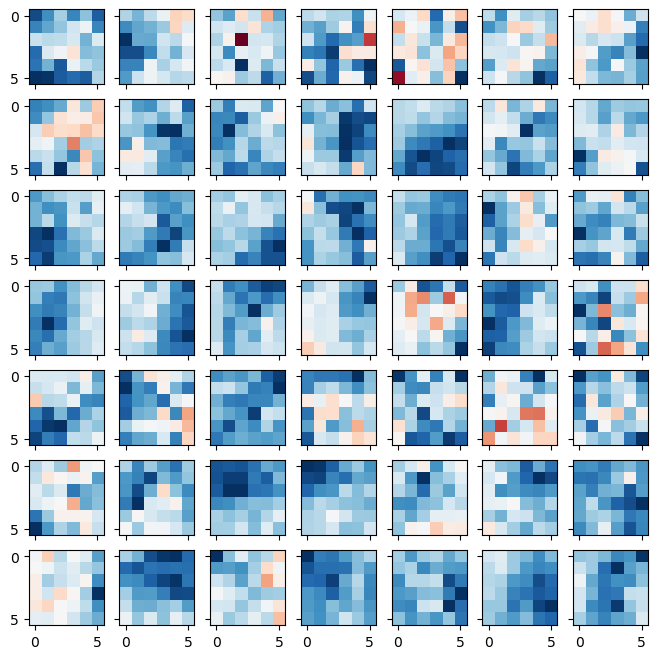

In [22]:
filters = model.encoder.weight.detach().cpu().numpy()

fig, ax = plt.subplots(7, 7, sharex=True, sharey=True, figsize=(8, 8))
for i in range(7):
    for j in range(7):
        crt_filter = filters[i * 7 + j, 0]
        crt_max = np.max(np.abs(crt_filter))
        ax[i][j].imshow(crt_filter, vmin=-crt_max, vmax=crt_max, cmap="RdBu")

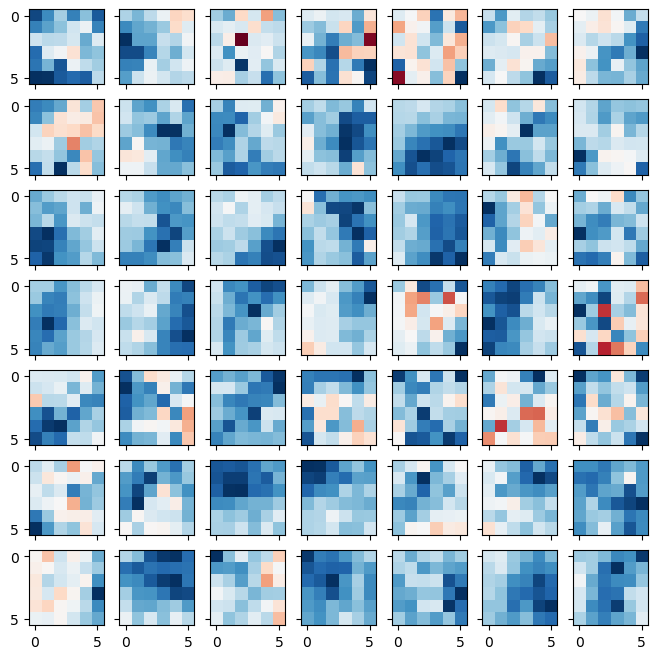

In [23]:
filters = new_model.encoders[0].weight.detach().cpu().numpy()

fig, ax = plt.subplots(7, 7, sharex=True, sharey=True, figsize=(8, 8))
for i in range(7):
    for j in range(7):
        crt_filter = filters[i * 7 + j, 0]
        crt_max = np.max(np.abs(crt_filter))
        ax[i][j].imshow(crt_filter, vmin=-crt_max, vmax=crt_max, cmap="RdBu")